In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames: 
        if filename == 'True.csv':
            true_news = pd.read_csv(os.path.join(dirname, filename))
        else:
            fake_news = pd.read_csv(os.path.join(dirname, filename))

In [3]:
print(' --- Real News --- ')
print(true_news.head(5))
print(' --- Fake News --- ')
print(fake_news.head(5))

 --- Real News --- 
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   
 --- Fake News --- 
                                               title  \
0 

In [5]:
# Let's indicate true news as 1 and fake news as 0
true_news['truth'] = len(true_news) * [1]
fake_news['truth'] = len(fake_news) * [0]
print(true_news.head(3))
print(fake_news.head(3))

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   

                 date  truth  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intellig

In [6]:
# Let's concatenate the two and prepare to shuffle up the data
all_news = pd.concat([true_news, fake_news], ignore_index=True) # ignore index to reset the indices

# Shuffle
all_news = all_news.sample(frac=1).reset_index(drop=True)

print(all_news.head(5))

                                               title  \
0  THREATS TO BUSINESS TO REMOVE TRUMP SIGN Promp...   
1  THE 1 PERCENTER BABY: Chelsea’s Daughter Is Cl...   
2  U.N. ends month-long Libya talks in Tunisia wi...   
3   Conservative Indiana Governor’s Stupid Respon...   
4  Several senior State Department officials leav...   

                                                text       subject  \
0  Please go to the BEST MULCH Facebook page and ...     left-news   
1  But then again, with all of the cash flowing i...      politics   
2  TUNIS (Reuters) - Month-long U.N.-backed talks...     worldnews   
3  Indiana Governor Mike Pence is at the center o...          News   
4  WASHINGTON (Reuters) - The Trump administratio...  politicsNews   

                date  truth  
0        Nov 1, 2016      0  
1        Jun 3, 2015      0  
2  October 21, 2017       1  
3  February 12, 2016      0  
4  January 26, 2017       1  


In [7]:
# Let's only keep title, text, and truth for now
all_news = all_news.drop(['date'], axis=1)
all_news = all_news.drop(['subject'], axis=1)
print(all_news.head(5))

                                               title  \
0  THREATS TO BUSINESS TO REMOVE TRUMP SIGN Promp...   
1  THE 1 PERCENTER BABY: Chelsea’s Daughter Is Cl...   
2  U.N. ends month-long Libya talks in Tunisia wi...   
3   Conservative Indiana Governor’s Stupid Respon...   
4  Several senior State Department officials leav...   

                                                text  truth  
0  Please go to the BEST MULCH Facebook page and ...      0  
1  But then again, with all of the cash flowing i...      0  
2  TUNIS (Reuters) - Month-long U.N.-backed talks...      1  
3  Indiana Governor Mike Pence is at the center o...      0  
4  WASHINGTON (Reuters) - The Trump administratio...      1  


In [8]:
# In this case, let's tokenize and then split
# First, let's find how big the vocabulary is without truncating
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_news['text']) # tokenizing just on text should be fine
word_index = tokenizer.word_index
print(len(word_index))


138021


In [9]:
# 138021 in total
del(tokenizer)

In [10]:
# Great, now let's do two splits on this dataset: one between train/validation and test,
# and another between train and validation
test_breakpoint = int(0.8 * len(all_news))
train_val_data = all_news[:test_breakpoint]
test_data = all_news[test_breakpoint:]

val_breakpoint = int(0.8 * len(train_val_data))
train_data = train_val_data[:val_breakpoint]
val_data = train_val_data[val_breakpoint:]

print(f'Length of training data: {len(train_data)}')
print(f'Length of validation data: {len(val_data)}')
print(f'Length of test data: {len(test_data)}')
print(f'Length of all news: {len(all_news)}')
# Numbers add up!

Length of training data: 28734
Length of validation data: 7184
Length of test data: 8980
Length of all news: 44898


In [18]:
# Let's tokenize
vocab_size = 50000
embedding_dim = 64
max_length = 150
max_length_title = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Separate train data
train_text = train_data['text']
train_titles = train_data['title']
train_truth = train_data['truth']

# Separate validation data
val_text = val_data['text']
val_titles = val_data['title']
val_truth = val_data['truth']

# Separate test data
test_text = test_data['text']
test_titles = test_data['title']
test_truth = test_data['truth']

# Get the vocabulary
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

# Tokenize the train texts
train_text_sequences = tokenizer.texts_to_sequences(train_text)
train_text_padded = np.array(pad_sequences(train_text_sequences, maxlen = max_length, \
                               padding=padding_type, truncating = trunc_type))

# Tokenize the train titles, with lower max length
train_titles_sequences = tokenizer.texts_to_sequences(train_titles)
train_titles_padded = np.array(pad_sequences(train_text_sequences, maxlen = max_length_title, \
                               padding=padding_type, truncating = trunc_type))
print(train_text[:2])
print(train_text_padded[:2])

0    Please go to the BEST MULCH Facebook page and ...
1    But then again, with all of the cash flowing i...
Name: text, dtype: object
[[ 1529   216     3     2   549     1   566   904     6   424    94     5
  10622    62  1755    43    56    11     2  3926   161    35    24  1398
   4132  1529   884   359     3   418    21     6   176  3537    17   117
     52    40    23    58    26 31050   427  7509  3165    34   107    44
      2    16   954   899     7   635     4   181   287   580   272   837
      4     2   954   115  2324    58   635    35   711     5  1685  1920
     26     5  1816  1004   379    51    12  1617   116     2   229    34
     40    25    23  8006    89  4141     2    16   954   900    96    15
   4274   577   181   112    12    82    19   513    19   181   287    34
     40  3833     8     2   954    18     3   731     6     3   314    11
     55     3  1925    49  5425     2 14657    18    60  2385   231     3
    137     2   954    50 19406     6   176    31 

In [16]:
# Tokenize validation texts and titles
val_text_sequences = tokenizer.texts_to_sequences(val_text)
val_text_padded = np.array(pad_sequences(val_text_sequences, maxlen = max_length, \
                               padding=padding_type, truncating = trunc_type))

val_titles_sequences = tokenizer.texts_to_sequences(val_titles)
val_titles_padded = np.array(pad_sequences(val_titles_sequences, maxlen = max_length_title, \
                               padding=padding_type, truncating = trunc_type))

# Tokenize test texts and titles
test_text_sequences = tokenizer.texts_to_sequences(test_text)
test_text_padded = np.array(pad_sequences(test_text_sequences, maxlen = max_length, \
                               padding=padding_type, truncating = trunc_type))

test_titles_sequences = tokenizer.texts_to_sequences(test_titles)
test_titles_padded = np.array(pad_sequences(test_text_sequences, maxlen = max_length_title, \
                               padding=padding_type, truncating = trunc_type))

[[  698 35234     1 ...     0     0     0]
 [ 9783 10451  1658 ...     0     0     0]
 [   79  1012  1023 ...     0     0     0]
 ...
 [  108  4806  1710 ...     0     0     0]
 [  294  6189  3701 ...     0     0     0]
 [ 4350   209  2255 ...     0     0     0]]


In [17]:
print(val_titles_padded[0])
print(val_text_padded[0])
print(test_titles_padded[0])
print(test_text_padded[0])

[  698 35234     1 16373   123  1212  2843  3094  6003   820     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[ 3094  6003  1033   761 38039    12    31 30081     3     2   390 17471
   101    85    10     2 11632 29564 19664  3644     6   727   357    10
 22669     9    83  1097  1173     2 16373   123  1212     2   105  2360
    12   359   110 17927  2214   714     3   514   478     6 17471     2
  3372    51  6615     6 39925  1229     6     2  4933    21    51    32
  2076     3  2815    94    47    69  1005    21 49865     8     2    97
    29   728 28977   196  1229     3  4391     2   182     6  1459    56
     2  2272   645   182     7     5   180  4898   250   634   196  1591
     8    27  1541    86   549    23  5054    21     5   988  3930     4
   481    88     3    53   201    21 

In [19]:
# We're all set! Let's make the model
import tensorflow.keras.layers as layers
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # hyperparameters set above
    #layers.GlobalAveragePooling1D(),
    #layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(32, activation='relu')),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 64)           3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 3,224,897
Trainable params: 3,224,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Let's prepare the data and train
train_data = (train_text_padded, train_titles_padded)
val_data = (val_text_padded, val_titles_padded)
num_epochs = 10
history = model.fit(train_data, train_truth, epochs=num_epochs, validation_data=(val_data, val_truth), verbose=2)

Epoch 1/10
898/898 - 70s - loss: 368767.2188 - accuracy: 0.9335 - val_loss: 0.7534 - val_accuracy: 0.8342
Epoch 2/10
898/898 - 78s - loss: 0.5042 - accuracy: 0.9511 - val_loss: 0.7601 - val_accuracy: 0.9315
Epoch 3/10
898/898 - 69s - loss: 0.4339 - accuracy: 0.9620 - val_loss: 0.7710 - val_accuracy: 0.9286
Epoch 4/10
898/898 - 69s - loss: 0.2922 - accuracy: 0.9652 - val_loss: 0.8138 - val_accuracy: 0.9258
Epoch 5/10
898/898 - 69s - loss: 0.2800 - accuracy: 0.9665 - val_loss: 0.6988 - val_accuracy: 0.9264
Epoch 6/10
898/898 - 69s - loss: 0.2232 - accuracy: 0.9680 - val_loss: 0.6260 - val_accuracy: 0.9264
Epoch 7/10
898/898 - 69s - loss: 0.2036 - accuracy: 0.9697 - val_loss: 0.5845 - val_accuracy: 0.9258
Epoch 8/10
898/898 - 69s - loss: 0.1615 - accuracy: 0.9717 - val_loss: 0.5029 - val_accuracy: 0.9255
Epoch 9/10
898/898 - 69s - loss: 0.1420 - accuracy: 0.9730 - val_loss: 0.4223 - val_accuracy: 0.9257
Epoch 10/10
898/898 - 70s - loss: 0.1151 - accuracy: 0.9734 - val_loss: 0.4166 - val_a

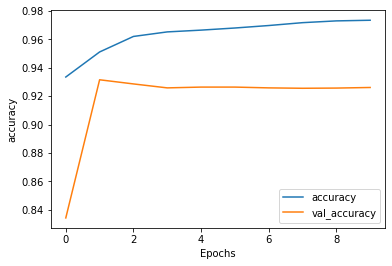

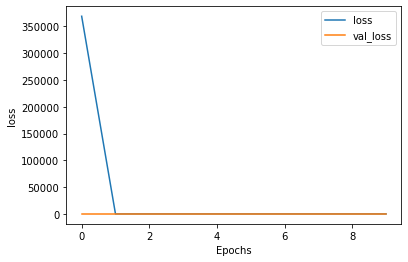

In [22]:
import matplotlib.pyplot as plt

# Some nice plots!

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
def predict(titles, texts, tokenizer=tokenizer, max_length=max_length, max_length_title=max_length_title, trunc_type=trunc_type, padding=padding_type):
    text_sequences = tokenizer.texts_to_sequences(texts)
    text_padded = pad_sequences(text_sequences, maxlen = max_length, \
                               padding=padding, truncating = trunc_type)
    titles_sequences = tokenizer.texts_to_sequences(titles)
    titles_padded = pad_sequences(titles_sequences, maxlen = max_length_title, \
                               padding=padding, truncating = trunc_type)
    predictions = model.predict((titles_padded, text_padded))
    return predictions

In [50]:
def accuracy(predictions, actual):
    assert len(predictions) == len(actual), "To compute accuracy, arrays must be same size"
    predictions = np.array(predictions)
    actual = np.array(actual)
    total_correct = 0.0
    for i in range(len(predictions)):
        if round(float(predictions[i])) == actual[i]:
            total_correct += 1
    return total_correct / len(predictions)

In [52]:
predictions = predict(test_titles, test_text)
print(accuracy(predictions, test_truth))
# nearly 80%, not too bad!

0.7958797327394209


In [ ]:
# I used a Kaggle dataset for this project, you can find it at
# https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset